## **Weather forecasts: model study**

#### **Model: DecTree**

In [68]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, precision_recall_fscore_support
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, SelectPercentile, mutual_info_classif
from sklearn.tree import DecisionTreeClassifier

**Params**

In [ ]:
DATASET = os.path.join("..", "..", "datasets", "weather.csv")
TEST_PCT = 0.30
FEATURES_TO_REMOVE = ["Unnamed: 0", "Date", "Location", "Evaporation", "Sunshine", "Cloud9am", "Cloud3pm", "Rainfall"]
TARGET = "RainTomorrow"
MODELNAME = "DecTree"

PARAM_GRID = {
    "feature_selection__percentile": [10, 20, 30, 40, 50]
}

Load dataset and clean NaN (see DataAnalysis.ipynb)

In [ ]:
data = pd.read_csv(DATASET)

data = data.drop(columns=FEATURES_TO_REMOVE).dropna().reset_index(drop=True)
data

,MinTemp,MaxTemp,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,13.4,22.9,W,44.0,W,WNW,20.0,24.0,71.0,22.0,1007.7,1007.1,16.9,21.8,No,No
1,7.4,25.1,WNW,44.0,NNW,WSW,4.0,22.0,44.0,25.0,1010.6,1007.8,17.2,24.3,No,No
2,12.9,25.7,WSW,46.0,W,WSW,19.0,26.0,38.0,30.0,1007.6,1008.7,21.0,23.2,No,No
3,9.2,28.0,NE,24.0,SE,E,11.0,9.0,45.0,16.0,1017.6,1012.8,18.1,26.5,No,No
4,17.5,32.3,W,41.0,ENE,NW,7.0,20.0,82.0,33.0,1010.8,1006.0,17.8,29.7,No,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112920,3.5,21.8,E,31.0,ESE,E,15.0,13.0,59.0,27.0,1024.7,1021.2,9.4,20.9,No,No
112921,2.8,23.4,E,31.0,SE,ENE,13.0,11.0,51.0,24.0,1024.6,1020.3,10.1,22.4,No,No
112922,3.6,25.3,NNW,22.0,SE,N,13.0,9.0,56.0,21.0,1023.5,1019.1,10.9,24.5,No,No
112923,5.4,26.9,N,37.0,SE,WNW,9.0,9.0,53.0,24.0,1021.0,1016.8,12.5,26.1,No,No


Prepare categorical to numerical conversion

In [71]:
data.dtypes

MinTemp          float64
MaxTemp          float64
WindGustDir       object
WindGustSpeed    float64
WindDir9am        object
WindDir3pm        object
WindSpeed9am     float64
WindSpeed3pm     float64
Humidity9am      float64
Humidity3pm      float64
Pressure9am      float64
Pressure3pm      float64
Temp9am          float64
Temp3pm          float64
RainToday         object
RainTomorrow      object
dtype: object

In [72]:
# Lists of column names for different data types
NUM_FEATS = data.select_dtypes(['float64']).columns.tolist()
CAT_FEATS = data.select_dtypes(['object']).columns.tolist()
CAT_FEATS.remove(TARGET)

FEATURES = NUM_FEATS + CAT_FEATS

#Encode target column:
data[TARGET] = np.where(data[TARGET] == "Yes", 1, 0)

# Create transformers for both numeric and categorical features
NUM_TRANSFORM = Pipeline(
    steps=[
        ("scaler", StandardScaler()),
    ]
)
CAT_TRANSFORM = Pipeline(
    steps=[
        ("encoder", OrdinalEncoder())
    ]
)

In [73]:
# Combine the transformations in a ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', NUM_TRANSFORM, NUM_FEATS),
        ('cat', CAT_TRANSFORM, CAT_FEATS)
    ]
)

Create targets

In [74]:
X = data[FEATURES]
Y = data[TARGET]

Train / test split

In [75]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=TEST_PCT, random_state=42)

X.shape, Y.shape, X_train.shape, Y_train.shape, X_test.shape, Y_test.shape

((112925, 15), (112925,), (79047, 15), (79047,), (33878, 15), (33878,))

Get pipeline

In [76]:
sk_pipe = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ("feature_selection", SelectPercentile(score_func=mutual_info_classif)),
    ('classifier', DecisionTreeClassifier(random_state=42))
])

Cross Validation for feature selection

Using "balanced_accuracy" as cross-validation metric, since it balances sensitivity (true positive rate or recall) and specificity (true negative rate) and it is generally used with imbalanced data (in the dataset, there are >26000 negative samples and only > 7600 positive samples).

In [77]:
# Find best model:
grid_search = GridSearchCV(sk_pipe, PARAM_GRID, cv=5, scoring='balanced_accuracy', n_jobs=-1, verbose=1)
grid_search.fit(X_train, Y_train)

# Get the best model:
best_percentile = grid_search.best_params_['feature_selection__percentile']
best_score = grid_search.best_score_
best_pipe = grid_search.best_estimator_

print("Best Percentile:", best_percentile)
print("Best cross-validated score:", best_score)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


Best Percentile: 50
Best cross-validated score: 0.6879955688298359


Train model

In [78]:
best_pipe.fit(X_train, Y_train)
print("Training complete.")

Training complete.


Get predictions

In [79]:
#PREDICT:
Y_preds = best_pipe.predict(X_test)

In [80]:
#add to Test set:
data_test = pd.DataFrame(data={"Y_test": Y_test, "Y_Pred": Y_preds})
data_test.reset_index(inplace=True)
data_test.rename(columns={"index": "RowID"}, inplace=True)
data_test

,RowID,Y_test,Y_Pred
0,108475,0,0
1,76656,0,0
2,22886,0,0
3,10740,0,0
4,1116,0,0
...,...,...,...
33873,32638,1,1
33874,72698,0,0
33875,60778,0,0
33876,88615,0,0


**Metrics**

Get confusion matrix

In [81]:
conf_matrix = pd.DataFrame(data=confusion_matrix(Y_test, Y_preds), columns=["Pred 0", "Pred 1"])

#Add matrix labels & totals:
conf_matrix["Tot Act"] = conf_matrix.aggregate("sum", axis=1)
conf_matrix.loc[len(conf_matrix.index)] = conf_matrix.aggregate("sum", axis=0)
conf_matrix.index=["Act 0", "Act 1", "Tot Pred"]

conf_matrix

,Pred 0,Pred 1,Tot Act
Act 0,22396,3856,26252
Act 1,3621,4005,7626
Tot Pred,26017,7861,33878


Calculate metrics

In [82]:
accuracy = accuracy_score(Y_test, Y_preds)
print(f"Accuracy: {accuracy*100:.1f}%")

metrics = {}

metrics["Precision"], metrics["Recall"], metrics["F-score"], metrics["Support"] = precision_recall_fscore_support(Y_test, Y_preds)

df_metrics = pd.DataFrame(data=metrics).T
df_metrics.columns = ["No", "Yes"]
df_metrics = df_metrics.round(2)
df_metrics

Accuracy: 77.9%


,No,Yes
Precision,0.86,0.51
Recall,0.85,0.53
F-score,0.86,0.52
Support,26252.00,7626.00


Feature importance

In [83]:
# Get selected features list:
selected_mask = best_pipe.named_steps['feature_selection'].get_support()
sel_features = X_train.columns[selected_mask]

# Build features importance dict:
imp_scores = best_pipe.named_steps['classifier'].feature_importances_
total = sum(imp_scores)
f_importance = {}

for i in range(len(sel_features)):
    f_importance[sel_features[i]] = imp_scores[i]/total
print(f_importance)

{'WindGustSpeed': np.float64(0.11402757524476706), 'Humidity9am': np.float64(0.11007337800312864), 'Humidity3pm': np.float64(0.3357937619775681), 'Pressure9am': np.float64(0.1338165244295206), 'Pressure3pm': np.float64(0.1457029395225485), 'Temp3pm': np.float64(0.1439745323135214), 'RainToday': np.float64(0.01661128850894562)}


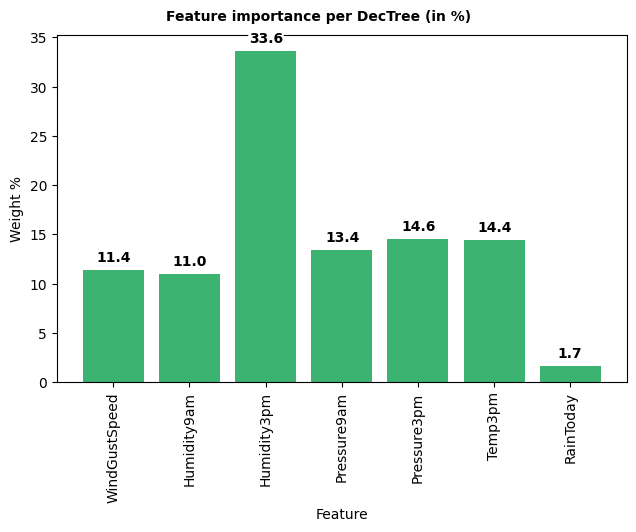

In [ ]:
# Plot:
fig, sub1 = plt.subplots(1, 1, figsize=(600/96, 500/96), constrained_layout=True)
fig.suptitle(f"Feature importance per {MODELNAME} (in %)", fontsize=10, fontweight='bold')

xpos = np.arange(len(f_importance.keys()))
ylist = [v*100 for v in f_importance.values()]
sub1.bar(xpos, ylist, color='mediumseagreen')

for x, y in zip(xpos, ylist):
    lab = f"{y:.1f}"
    xoff = 12 if len(lab) > 3 else 9
    yoff = 4
    plt.annotate(text=f"{y:.1f}",
                xy=(x, y),
                xytext=(-xoff, yoff), #distance from text to points (x,y)
                textcoords="offset points",
                fontweight="bold",
                bbox=dict(boxstyle='round, pad=0', fc='white', ec='1'))

sub1.set_xlabel("Feature")
sub1.set_ylabel("Weight %")
sub1.set_xticks(xpos)
sub1.set_xticklabels(f_importance.keys(), rotation=90)
plt.show()